This analysis mostly follows this [Lister paper](https://www.sciencedirect.com/science/article/pii/S0092867422012582), code available [here](https://doi.org/10.5281/zenodo.7113422), at the `snRNAseq/notebooks/` subdirectory.

IMPORTANT: Make sure you open settings.py and modify those settings as needed

In [1]:
# Built-in
import math
import os
import json

# Analysis packages
import scanpy as sc
import scrublet as scr
import numpy as np
import pandas as pd
from scipy import stats

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sb
# seaborn settings for plot
sb.set_theme(context="paper", style="whitegrid")

# Set number of cores to use
sc.settings.n_jobs = 36

sc.logging.print_header()

scanpy==1.10.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.0 scipy==1.13.1 pandas==1.5.3 scikit-learn==1.5.0 statsmodels==0.13.5 igraph==0.11.6 pynndescent==0.5.8


In [2]:
# Set autoreload settings. With this code,
# changing settings.py (see next cell) automatically loads the new settings in here too.
%load_ext autoreload
%autoreload 1

In [3]:
# Modify settings from this file (figure path, subsetting settings, etc)
# The file is located in this directory (settings.py)
%aimport settings

# Read and Combine h5ad files

In [4]:
samples = pd.read_csv("../PsiloKet snRNA Seq (2022-11-19).csv").astype({"Mouse ID": str})
# Select samples with NO reason for exclusion
samples = samples[samples["Reason for Exclusion"].isna()]

# Fix mis-sexed samples
# See 02.5_sex_determination
# Clara: I compared the spreadsheet with my notebook and see #470 is male but I sorted it as F on the spreadsheet.
samples.loc[np.isin(samples['Mouse ID'], ["470"]), 'Sex'] = 'M'

# Swap 344 and 338 since they were opposite sex and most likely the other sample
samples.loc[np.isin(samples['Mouse ID'], ["344"]), 'Seq ID'] = '6141-CL-3'
samples.loc[np.isin(samples['Mouse ID'], ["338"]), 'Seq ID'] = '6141-CL-4'


if settings.cellranger:
    samples['Folder'] = "../cellranger/" + samples['Seq ID']
else:
    # Add location of loom file from kallisto-bustools
    samples['Folder'] = "../kb/" + samples['Seq ID']


# Important: To use this code, copy the subset samples into kb-subset
# TODO remove this once we determine if we are going to subset or not
if settings.use_subset and not settings.cellranger:
    samples["Folder"] = samples.apply(lambda row: row["Folder"].replace("kb", "kb-subset") if row["reads/cell requested"] != "25K" else row["Folder"], axis=1)

if settings.cellranger:
    samples['Filename'] = samples['Folder'] + "/outs/filtered_feature_bc_matrix.h5"
else:
    samples['Filename'] = samples['Folder'] + "/counts_filtered/adata.h5ad"


# Convert Timepoint to int
samples["Timepoint"] = samples["Timepoint"].str[:-1].astype(int)

samples.head()

Mouse ID  Drug  Timepoint Sex Mouse sac'd nuclei processed?     Seq ID  \
0      346  none          0   F      4/5/22              DONE  6155-CL-1   
1      347  none          0   F      4/5/22              DONE  6128-CL-1   
2      465  none          0   F     6/29/22              DONE  6881-CL-1   
3      467  none          0   F     6/29/22              DONE  6881-CL-2   
5      291  none          0   M     3/30/22              DONE  5889-CL-1   

  reads/cell requested seq data received on Globus, transfered to kykwan  \
0                  25K                                               yes   
1                  25K                                               yes   
2                  25K                                               NaN   
3                  25K                                               NaN   
5                  25K                                               yes   

  Reason for Exclusion                   Folder  \
0                  NaN  ../cellranger/6155-CL-1   
1                  NaN  ../cellranger/6128-CL-1   
2                  NaN  ../cellranger/6881-CL-1   
3                  NaN  ../cellranger/6881-CL-2   
5                  NaN  ../cellranger/5889-CL-1   

                                            Filename  
0  ../cellranger/6155-CL-1/outs/filtered_feature_...  
1  ../cellranger/6128-CL-1/outs/filtered_feature_...  
2  ../cellranger/6881-CL-1/outs/filtered_feature_...  
3  ../cellranger/6881-CL-2/outs/filtered_feature_...  
5  ../cellranger/5889-CL-1/outs/filtered_feature_...

In [5]:
samples.loc[np.isin(samples['Mouse ID'], ["344", "338", "470"]),]

Mouse ID   Drug  Timepoint Sex Mouse sac'd nuclei processed?     Seq ID  \
8       470   none          0   M         NaN              DONE  6889-CL-2   
14      344  Psilo          4   F      4/6/22              DONE  6141-CL-3   
42      338    Ket          2   M      4/6/22              DONE  6141-CL-4   

   reads/cell requested seq data received on Globus, transfered to kykwan  \
8                   25K                                               yes   
14                  25K                                               yes   
42                  25K                                               yes   

   Reason for Exclusion                   Folder  \
8                   NaN  ../cellranger/6889-CL-2   
14                  NaN  ../cellranger/6141-CL-3   
42                  NaN  ../cellranger/6141-CL-4   

                                             Filename  
8   ../cellranger/6889-CL-2/outs/filtered_feature_...  
14  ../cellranger/6141-CL-3/outs/filtered_feature_...  
42  ../cellranger/6141-CL-4/outs/filtered_feature_...

In [6]:
samples[samples["reads/cell requested"] != "25K"]

Mouse ID   Drug  Timepoint Sex Mouse sac'd nuclei processed?     Seq ID  \
19       41  Psilo          1   M     7/28/21              DONE  4806-CL-1   
21       42  Psilo          2   M     7/28/21              DONE  4806-CL-2   
45       39    Ket         24   M     7/28/21              DONE  4797-CL-1   
48       40    Ket         72   M     7/29/21              DONE  4797-CL-2   

   reads/cell requested seq data received on Globus, transfered to kykwan  \
19          250k (oops)                                               yes   
21          250k (oops)                                               yes   
45          250k (oops)                                               yes   
48          250k (oops)                                               yes   

   Reason for Exclusion                   Folder  \
19                  NaN  ../cellranger/4806-CL-1   
21                  NaN  ../cellranger/4806-CL-2   
45                  NaN  ../cellranger/4797-CL-1   
48                  NaN  ../cellranger/4797-CL-2   

                                             Filename  
19  ../cellranger/4806-CL-1/outs/filtered_feature_...  
21  ../cellranger/4806-CL-2/outs/filtered_feature_...  
45  ../cellranger/4797-CL-1/outs/filtered_feature_...  
48  ../cellranger/4797-CL-2/outs/filtered_feature_...

In [7]:
# Drop some samples to test if the clusters still create wisps
dropped_samples = [
    "39",
    "40",
    "41",
    "42",
    "299",
    "301"
]

if settings.drop_samples:
    samples = samples[~np.in1d(samples["Mouse ID"], dropped_samples)]

In [8]:
samples.groupby(["Drug", "Timepoint"]).count()["Mouse ID"]

Drug   Timepoint
Ket    1            3
       2            4
       4            4
       24           3
       72           3
Psilo  1            3
       2            3
       4            4
       24           3
       72           4
none   0            8
Name: Mouse ID, dtype: int64

In [9]:
def read_kb_record(file):
    with open(file, "r") as f:
        return json.loads(f.read())

In [10]:
def process_h5ad(row):
    if settings.cellranger:
        adata = sc.read_10x_h5(row["Filename"])
    else:
        adata = sc.read(row["Filename"])
    
    # Move gene_id index to a separate column
    # If this line fails, check that pandas>=1.5.3
    adata.var = adata.var.reset_index(names='gene_name')
    
    adata.var['non-unique_names'] = adata.var["gene_name"].astype(str)
    adata.var_names = adata.var["gene_name"].astype(str)
    adata.var_names_make_unique()
    adata.var["gene_name"] = adata.var_names
    
        
    adata.obs["time"] = row["Timepoint"]
    adata.obs["time_str"] = adata.obs["time"].astype(str)
    adata.obs["drug"] = row["Drug"]
    adata.obs["sex"] = row["Sex"]
    adata.obs["approx_reads_per_cell"] = row["reads/cell requested"]
    adata.obs["date"] = row["Mouse sac'd"]
    adata.obs["label"] = f"{row['Timepoint']}h_{row['Drug']}_{row['Sex']}_{row['Mouse ID']}"
    adata.obs["batch"] = row["Seq ID"][:4]
    adata.obs["seq_id"] = row["Seq ID"]
    
    if not settings.cellranger:
        kallisto_records = read_kb_record(row["Folder"] + "/run_info.json")
        bustools_records = read_kb_record(row["Folder"] + "/inspect.json")
        adata.obs = (adata.obs.assign(**kallisto_records, **bustools_records)
                     .drop(["call", "start_time", "kallisto_version", "index_version"], axis=1))
    
    adata.obs_names = adata.obs_names + '-' + adata.obs["label"]
    
    return adata

adata_list = samples.apply(process_h5ad, axis=1).to_numpy()
adata = sc.AnnData.concatenate(*adata_list, join='inner',
                               batch_key='sample', # default is batch, which overwrites actual batch data
                               # Do not make index unique since this is already accounted for in process_loom
                              index_unique=None)

/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique

/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix

/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion 

In [11]:
adata.obs["label"].value_counts()

72h_Psilo_F_378    10822
24h_Ket_M_335      10747
1h_Psilo_F_352     10120
72h_Psilo_M_373    10067
0h_none_M_470      10061
24h_Psilo_M_343     9983
72h_Psilo_F_392     9747
4h_Ket_F_350        9741
72h_Ket_M_334       9293
0h_none_F_467       9223
24h_Psilo_M_371     9217
4h_Psilo_F_344      9029
24h_Psilo_F_345     9006
72h_Ket_F_391       8879
1h_Psilo_M_341      8791
2h_Ket_F_353        8696
1h_Ket_F_354        8554
0h_none_F_466       8513
1h_Ket_M_445        8494
2h_Ket_M_338        8230
0h_none_F_465       8216
4h_Psilo_M_342      8209
0h_none_F_346       8180
1h_Ket_F_408        8112
0h_none_M_469       8029
72h_Ket_F_441       7911
0h_none_M_291       7908
2h_Psilo_M_339      7903
1h_Psilo_F_303      7903
2h_Ket_F_305        7804
2h_Psilo_F_349      7607
72h_Psilo_M_375     7470
0h_none_F_347       7470
4h_Ket_M_337        7383
24h_Ket_F_309       7340
4h_Ket_M_296        7261
4h_Ket_F_307        7231
2h_Ket_M_297        7217
4h_Psilo_F_306      6979
2h_Psilo_F_302      6766


In [19]:
adata[adata.obs['drug'] == "None"].obs['time'].shape

(0,)

In [12]:
# Example of gene made unique
adata.var[adata.var["non-unique_names"]=="Pakap"]

gene_name            gene_ids    feature_types genome  \
gene_name                                                         
Pakap         Pakap  ENSMUSG00000090053  Gene Expression   mm10   
Pakap-1     Pakap-1  ENSMUSG00000038729  Gene Expression   mm10   

          non-unique_names  
gene_name                   
Pakap                Pakap  
Pakap-1              Pakap

In [13]:
adata.obs.tail()

time time_str drug sex  \
TTTGTTGGTCGGCACT-1-72h_Ket_M_334    72       72  Ket   M   
TTTGTTGTCACCTCTG-1-72h_Ket_M_334    72       72  Ket   M   
TTTGTTGTCCTAAACG-1-72h_Ket_M_334    72       72  Ket   M   
TTTGTTGTCGACGCGT-1-72h_Ket_M_334    72       72  Ket   M   
TTTGTTGTCGGAGTAG-1-72h_Ket_M_334    72       72  Ket   M   

                                 approx_reads_per_cell     date  \
TTTGTTGGTCGGCACT-1-72h_Ket_M_334                   25K  4/19/22   
TTTGTTGTCACCTCTG-1-72h_Ket_M_334                   25K  4/19/22   
TTTGTTGTCCTAAACG-1-72h_Ket_M_334                   25K  4/19/22   
TTTGTTGTCGACGCGT-1-72h_Ket_M_334                   25K  4/19/22   
TTTGTTGTCGGAGTAG-1-72h_Ket_M_334                   25K  4/19/22   

                                          label batch     seq_id sample  
TTTGTTGGTCGGCACT-1-72h_Ket_M_334  72h_Ket_M_334  6163  6163-CL-4     41  
TTTGTTGTCACCTCTG-1-72h_Ket_M_334  72h_Ket_M_334  6163  6163-CL-4     41  
TTTGTTGTCCTAAACG-1-72h_Ket_M_334  72h_Ket_M_334  6163  6163-CL-4     41  
TTTGTTGTCGACGCGT-1-72h_Ket_M_334  72h_Ket_M_334  6163  6163-CL-4     41  
TTTGTTGTCGGAGTAG-1-72h_Ket_M_334  72h_Ket_M_334  6163  6163-CL-4     41

In [14]:
# Free up memory
del adata_list

In [41]:
adata.uns['label_order'] = adata.obs[["label", "time"]].sort_values(by="time")["label"].unique()

In [42]:
cmaps = ["Greys", "Greens", "Blues", "Purples", "Oranges", "Reds"]
# When generating the color map, skip the first few colors because they are too light
num_skip = 1
label_colors = (adata.obs.sort_values(by="time").groupby("time").nunique()
                .assign(colors=cmaps)
                .apply(lambda row: sb.color_palette(row["colors"], row["sample"]+num_skip).as_hex()[num_skip:], axis=1)
                .apply(pd.Series).stack().set_axis(adata.uns['label_order']))
label_colors.head()

0h_none_F_346    #e2e2e2
0h_none_M_469    #cecece
0h_none_F_466    #b5b5b5
0h_none_M_291    #959595
0h_none_M_470    #7a7a7a
dtype: object

In [43]:
adata.uns['label_colors'] = label_colors.index.to_numpy()
adata.uns['label_colors_dict'] = label_colors.to_dict()


stage_ordered_colors = [c.lower()[:-1] for c in cmaps]
adata.uns['stage_order'] = adata.obs.sort_values(by="time").time.unique()
adata.uns['stage_colors_dict'] = dict( zip( [str(s) for s in adata.uns['stage_order']],
                                           stage_ordered_colors))

In [44]:
adata

AnnData object with n_obs × n_vars = 352821 × 32285
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names'
    uns: 'label_order', 'label_colors', 'label_colors_dict', 'stage_order', 'stage_colors_dict'

# Clean and Filter

In [45]:
# get scanpy quality metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True);

In [46]:
adata

AnnData object with n_obs × n_vars = 352821 × 32285
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'label_order', 'label_colors', 'label_colors_dict', 'stage_order', 'stage_colors_dict'

In [47]:
# color = "approx_reads_per_cell"
# with plt.rc_context({'figure.figsize': (15,10)}):
#     sc.pl.scatter(adata[adata.obs['total_counts']<75000], 'total_counts', 'n_genes_by_counts',
#                   color=color, show=False, size=5,
#                   groups=["250k (oops)", "25K"], palette=sb.color_palette()[1::-1])
    
#     sc.pl.scatter(adata[adata.obs['total_counts']<75000], 'total_counts', 'n_genes_by_counts',
#                   color=color, show=False, size=5,
#                   groups=["25K", "250k (oops)"], palette=sb.color_palette()[1::-1])

In [48]:
# remove genes with fewer than 5 total counts
sc.pp.filter_genes(adata, min_counts=5, inplace=True)
# remove cells with fewer than 5 total counts (The actual threshold will be calculated again)
sc.pp.filter_cells(adata, min_counts=5)

# Filter cells and genes for sc.external.pp.scrublet
# See https://github.com/scverse/scanpy/issues/2377
# See https://github.com/scverse/scanpy/blob/master/scanpy/external/pp/_scrublet.py#L175-L176
sc.pp.filter_cells(adata, min_genes=3)
sc.pp.filter_genes(adata, min_cells=3)

In [49]:
raw_shape = adata.shape
adata.shape

(352821, 27330)

## Doublets

In [50]:
sc.external.pp.scrublet(adata, batch_key = "label")

/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.16
Detected doublet rate = 5.9%
Estimated detectable doublet fraction = 60.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.9%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 3.4%
Estimated detectable doublet fraction = 47.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.2%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.17
Detected doublet rate = 5.6%
Estimated detectable doublet fraction = 57.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.7%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.14
Detected doublet rate = 7.5%
Estimated detectable doublet fraction = 65.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 11.5%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.16
Detected doublet rate = 6.6%
Estimated detectable doublet fraction = 62.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.6%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 20.0%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.0%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.13
Detected doublet rate = 9.7%
Estimated detectable doublet fraction = 63.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 15.2%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.17
Detected doublet rate = 6.3%
Estimated detectable doublet fraction = 59.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.6%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.27
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 44.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.5%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 11.8%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 13.8%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 3.8%
Estimated detectable doublet fraction = 38.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.0%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.4%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 14.8%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.2%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.18
Detected doublet rate = 5.4%
Estimated detectable doublet fraction = 58.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.2%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.3%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.19
Detected doublet rate = 4.3%
Estimated detectable doublet fraction = 55.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.7%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.20
Detected doublet rate = 4.5%
Estimated detectable doublet fraction = 49.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.1%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.14
Detected doublet rate = 7.8%
Estimated detectable doublet fraction = 63.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 12.2%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 66.7%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.16
Detected doublet rate = 6.4%
Estimated detectable doublet fraction = 58.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 11.0%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.16
Detected doublet rate = 6.9%
Estimated detectable doublet fraction = 60.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 11.4%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.12
Detected doublet rate = 9.8%
Estimated detectable doublet fraction = 65.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 14.9%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.20
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 55.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.2%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.16
Detected doublet rate = 6.4%
Estimated detectable doublet fraction = 58.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 11.0%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 3.7%
Estimated detectable doublet fraction = 50.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.3%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 20.0%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.14
Detected doublet rate = 7.3%
Estimated detectable doublet fraction = 60.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 12.1%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 13.3%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 3.7%
Estimated detectable doublet fraction = 54.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.8%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.22
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 45.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.4%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.7%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.17
Detected doublet rate = 5.8%
Estimated detectable doublet fraction = 56.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.1%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.20
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 48.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.1%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.17
Detected doublet rate = 6.8%
Estimated detectable doublet fraction = 56.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 12.0%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.19
Detected doublet rate = 4.9%
Estimated detectable doublet fraction = 51.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.5%


/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/yamanq/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.22
Detected doublet rate = 4.1%
Estimated detectable doublet fraction = 41.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.8%


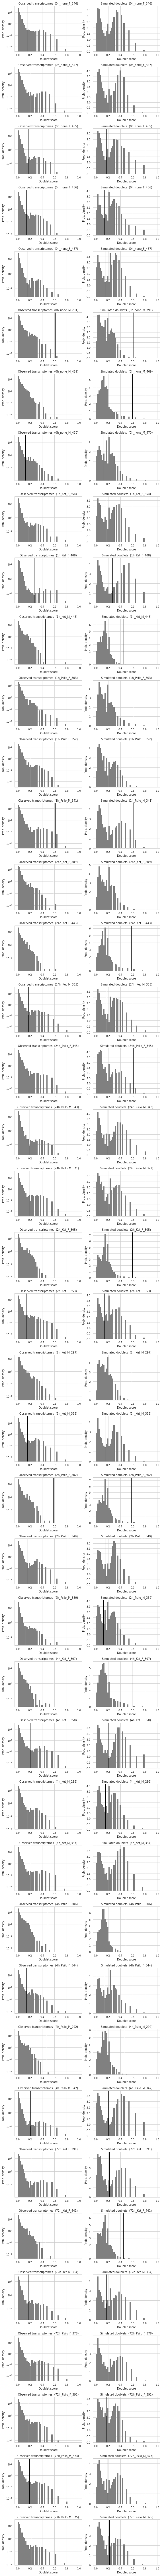

<Figure size 432x288 with 0 Axes>

In [51]:
sc.external.pl.scrublet_score_distribution(adata)
plt.savefig(f"{settings.fig_path}/doublet-simulations.png", format='png', bbox_inches='tight')

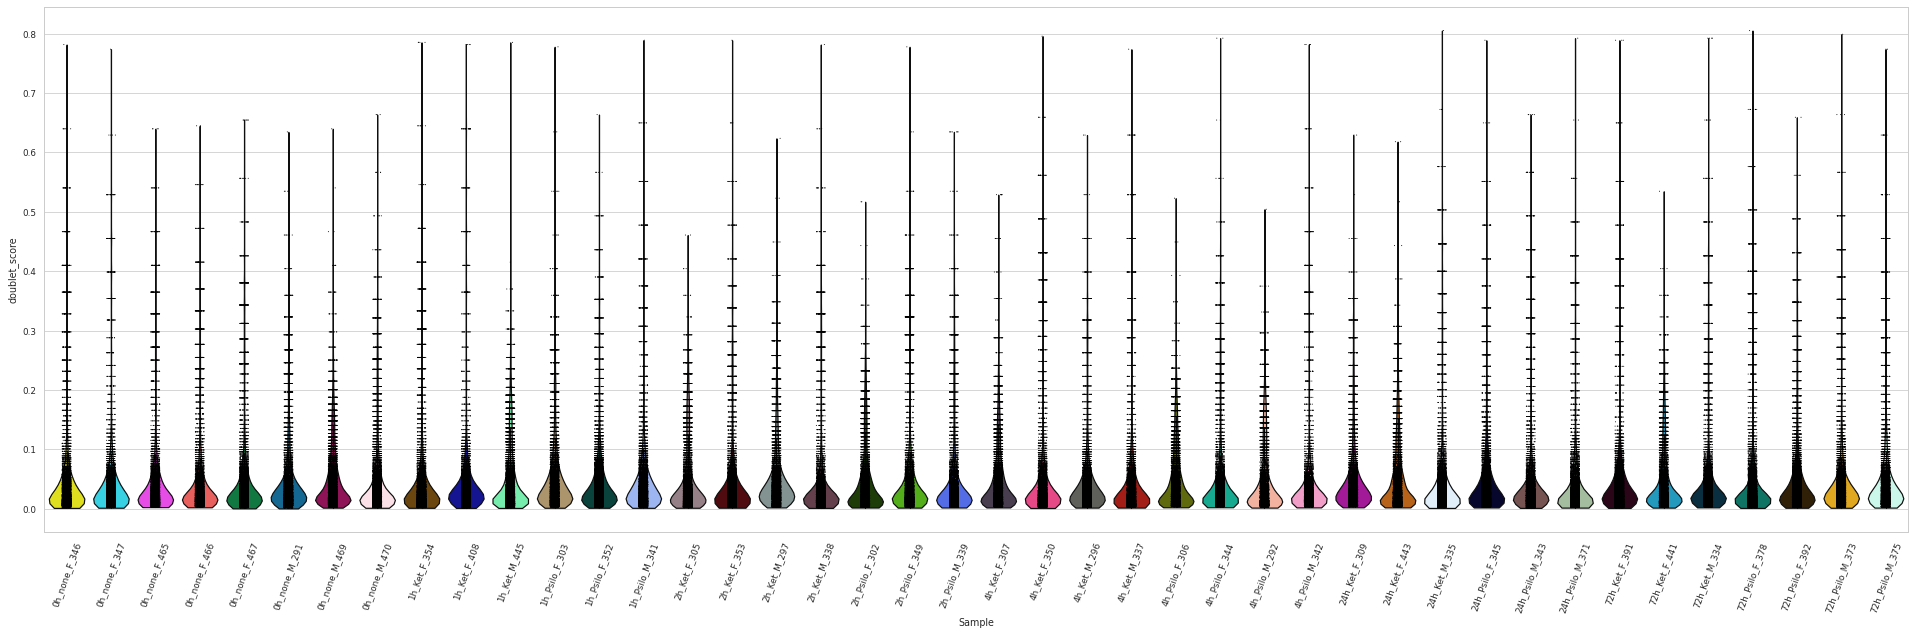

In [52]:
with plt.rc_context({'figure.figsize': (25,10)}):
    ax = sc.pl.violin(adata, ['doublet_score'], groupby='label', stripplot=True,
                      inner='box', rotation=70, xlabel='Sample', show=False)
    plt.savefig(f"{settings.fig_path}/violin-doublet-scores-pre-filtering.png", format='png', bbox_inches='tight')

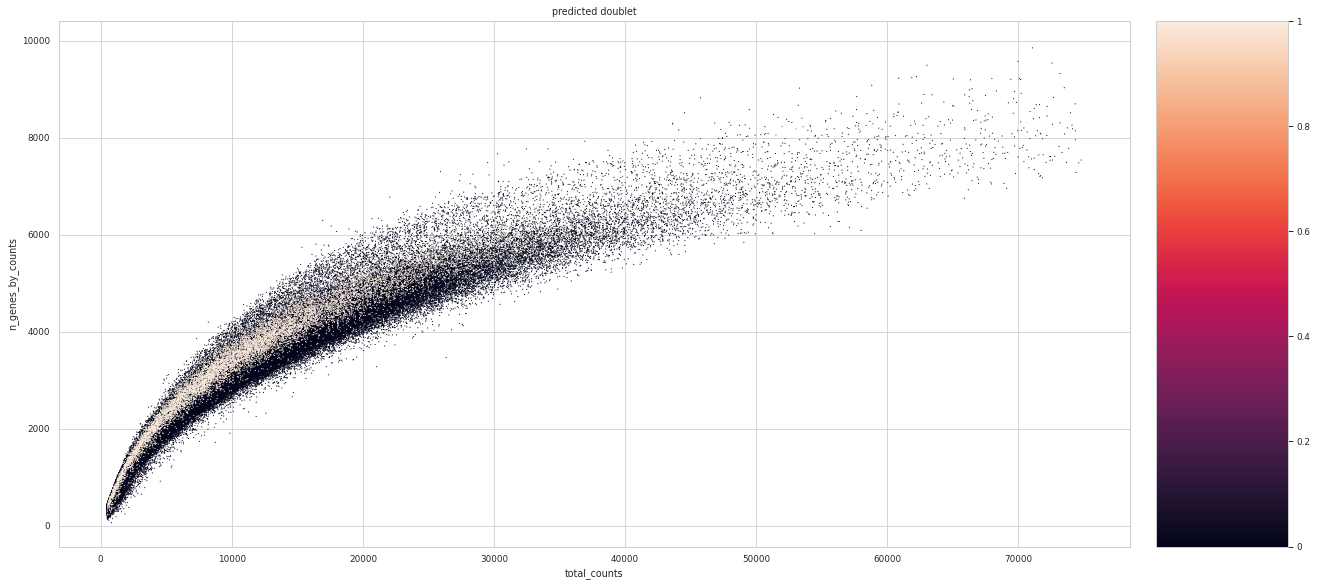

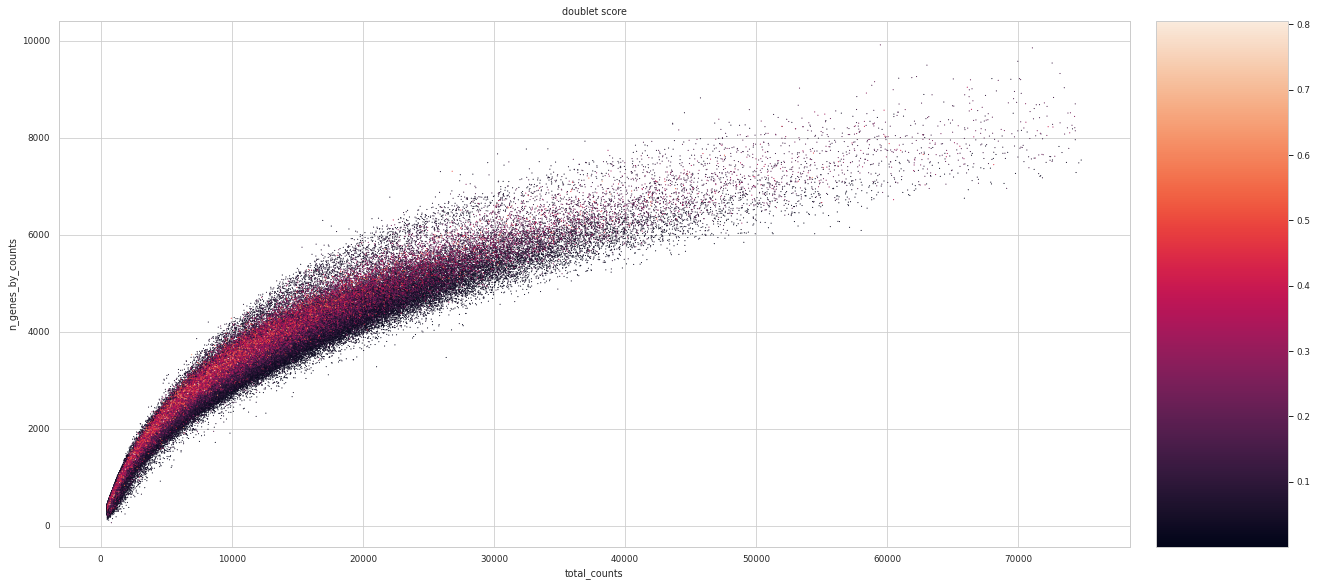

In [53]:
with plt.rc_context({'figure.figsize': (15,10)}):
    sc.pl.scatter(adata[adata.obs['total_counts']<75000], 'total_counts', 'n_genes_by_counts',
                  color="predicted_doublet", show=False, size=5)
    
    sc.pl.scatter(adata[adata.obs['total_counts']<75000], 'total_counts', 'n_genes_by_counts',
                  color="doublet_score", show=False, size=5)

In [54]:
adata.obs[adata.obs["predicted_doublet"]].groupby("label").size().sort_values(ascending=False)

label
0h_none_M_470      972
2h_Psilo_M_339     777
2h_Ket_F_353       675
72h_Psilo_F_392    663
4h_Psilo_F_344     660
0h_none_F_466      640
0h_none_F_467      607
24h_Ket_M_335      577
1h_Ket_F_354       537
72h_Ket_M_334      535
2h_Ket_M_338       527
2h_Psilo_F_349     524
72h_Psilo_M_373    490
0h_none_F_346      484
4h_Ket_M_296       464
0h_none_F_465      460
72h_Psilo_F_378    430
24h_Psilo_M_343    426
24h_Psilo_M_371    414
4h_Ket_F_350       389
1h_Psilo_F_352     384
4h_Psilo_M_342     304
72h_Psilo_M_375    303
72h_Ket_F_391      297
4h_Ket_M_337       271
0h_none_F_347      255
1h_Ket_F_408       199
1h_Psilo_M_341      13
24h_Psilo_F_345      5
1h_Psilo_F_303       4
24h_Ket_F_309        2
24h_Ket_F_443        2
2h_Ket_M_297         1
4h_Psilo_M_292       1
72h_Ket_F_441        1
1h_Ket_M_445         1
4h_Psilo_F_306       1
0h_none_M_469        1
0h_none_M_291        1
2h_Ket_F_305         0
2h_Psilo_F_302       0
4h_Ket_F_307         0
dtype: int64

In [55]:
# remove predicted doublets
adata = adata[~adata.obs["predicted_doublet"]]
adata.obs = adata.obs.drop(["predicted_doublet"], axis=1)
adata.shape

(339524, 27330)

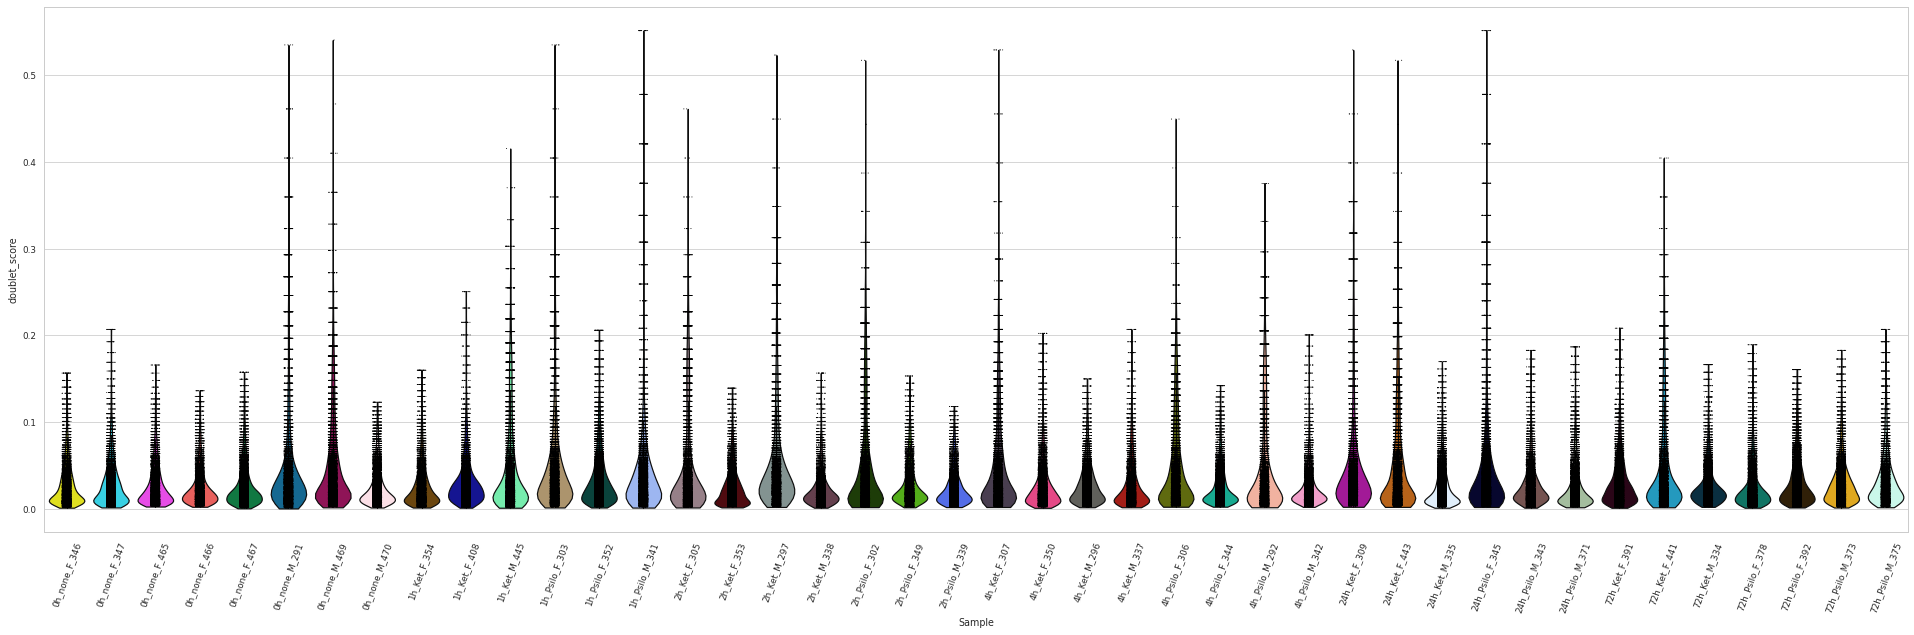

In [56]:
with plt.rc_context({'figure.figsize': (25,10)}):
    ax = sc.pl.violin(adata, ['doublet_score'], groupby='label', stripplot=True,
                      inner='box', rotation=70, xlabel='Sample', show=False)
    plt.savefig(f"{settings.fig_path}/violin-doublet-scores-post-filtering.png", format='png', bbox_inches='tight')

In [57]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)

/home/yamanq/.local/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


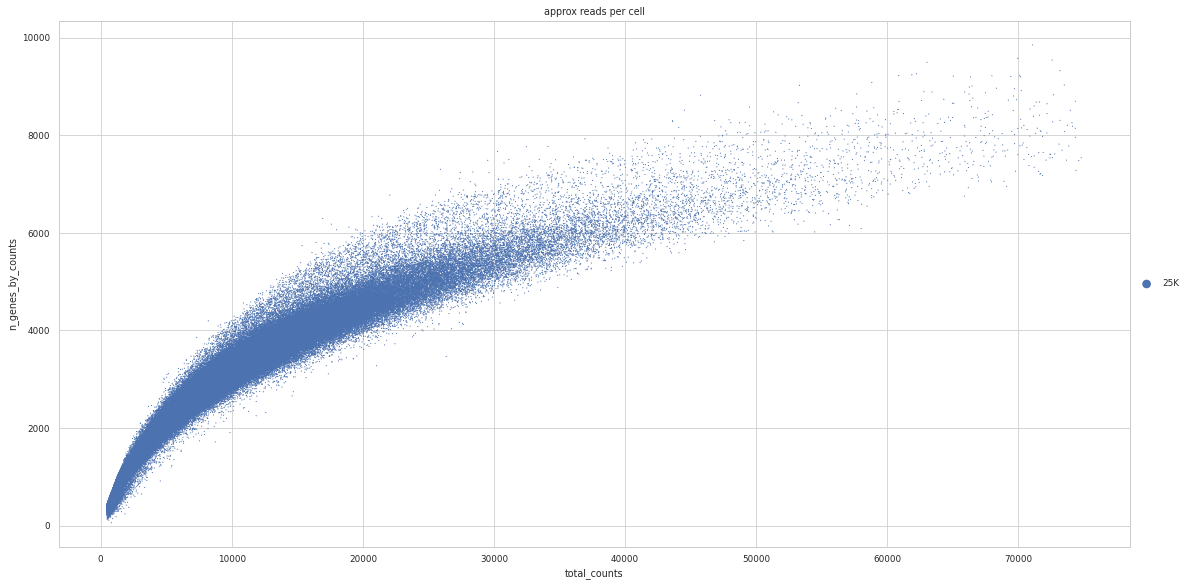

In [58]:
with plt.rc_context({'figure.figsize': (15,10)}):
    sc.pl.scatter(adata[adata.obs['total_counts']<75000], 'total_counts', 'n_genes_by_counts',
                  color="approx_reads_per_cell", show=False, size=5)

## Library size and feature counts per sample

In [59]:
adata.obs['log10_gene_counts'] = np.log10(adata.obs['n_genes_by_counts'])
adata.obs['log10_UMI_counts']  = np.log10(adata.obs['total_counts'])

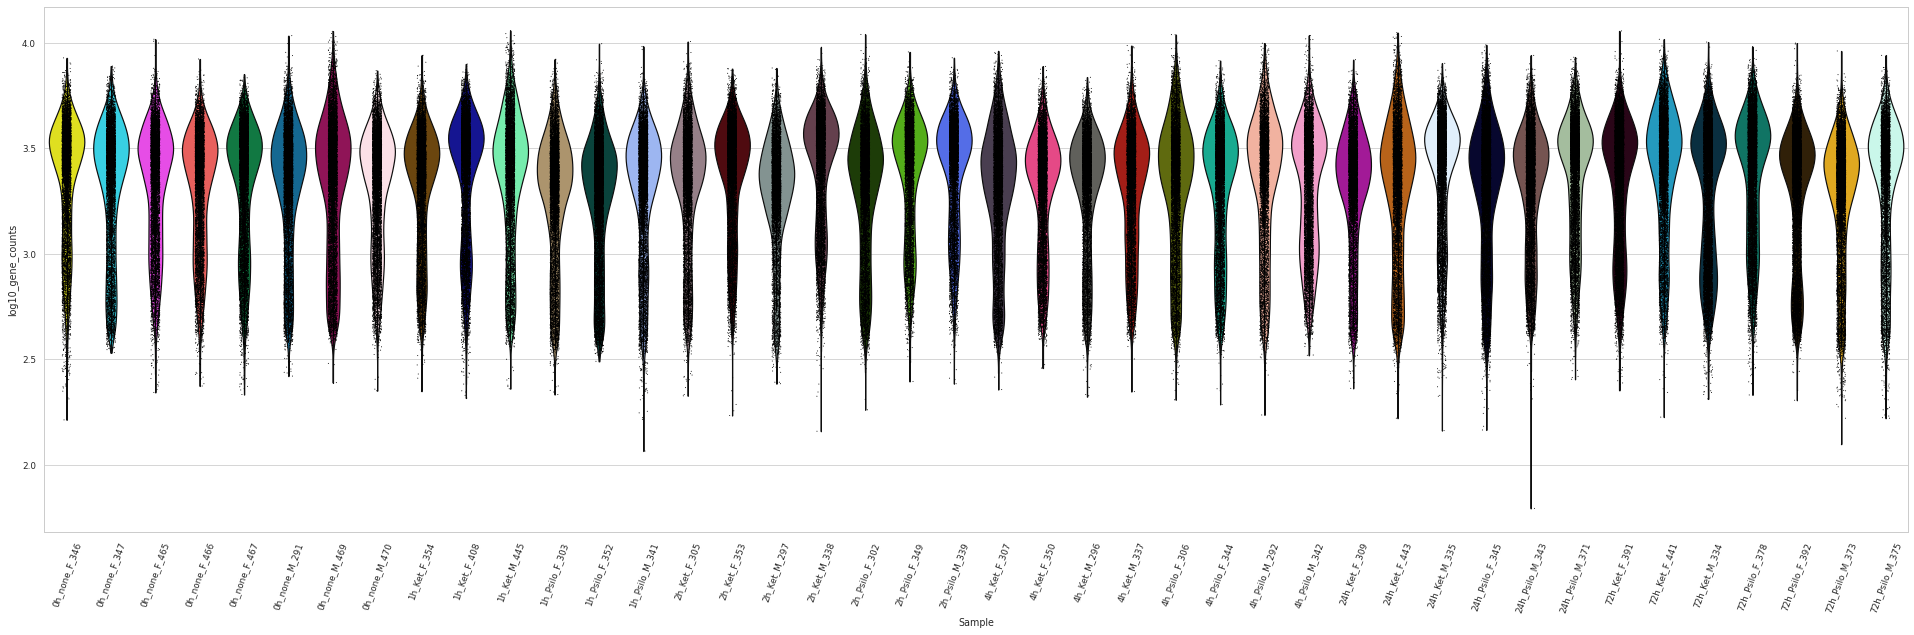

In [60]:
with plt.rc_context({'figure.figsize': (25,10)}):
    ax = sc.pl.violin(adata, ['log10_gene_counts'], groupby='label', stripplot=True, 
                  inner='box', rotation=70, xlabel='Sample', show=False)
    plt.savefig(f"{settings.fig_path}/violin_feature-cts.png", format='png', bbox_inches='tight')

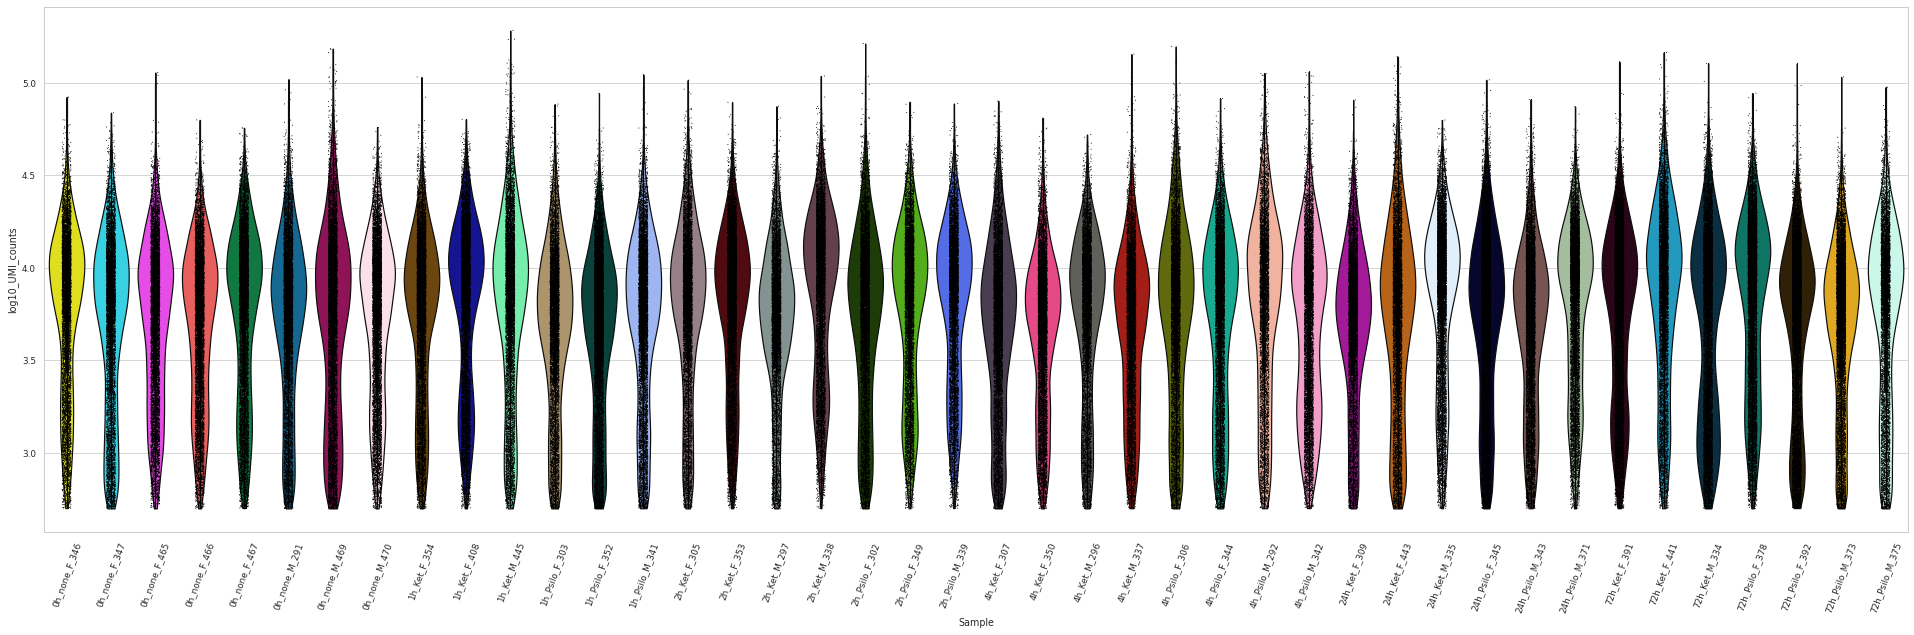

In [61]:
with plt.rc_context({'figure.figsize': (25,10)}):
    ax = sc.pl.violin(adata, ['log10_UMI_counts'], groupby='label', stripplot=True, 
                  inner='box', rotation=70, xlabel='Sample', show=False)
    plt.savefig(f"{settings.fig_path}/violin_library-sizes.png", format='png', bbox_inches='tight')

In [62]:
# Return adata with nuclei masked and print number removed from each batch
def mask_cells(adata, mask):
    sample_counts = pd.value_counts(adata.obs.label[~mask])
    print("Number of removed nuclei per sample:")
    print(sample_counts[sample_counts>0].to_string())
    print("Total removed = ", sample_counts.values.sum())
    return(adata[mask,:])

In [63]:
# plot log feature counts per nucs and return low nuc mask by median absolute deviation
# will return bool mask for nuc with less than 3 MADs of gene counts, but will not remove nuclei over max_th gene counts
def plot_mask_feature_per_nuc(adata, feature, max_th, xlab, mad_scale=3.0):
    # use scanpy's built QCs metrics
    sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True);
    # max threshold in log space
    max_th = np.log10(max_th)
    low_feat_mask = np.zeros(adata.shape[0], dtype=bool)

    # subplot params
    n    = len(adata.uns['label_order'])
    cols = 8
    rows = int(np.ceil(n / cols))
    size = cols * rows
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), sharex=True)
    # loop through each sample
    for i, (sample, ax) in enumerate(zip(adata.uns['label_order'], axes.flatten())):
        bat_mk = adata.obs['label'].values==sample
        # get feature counts as calculated by scanpy
        bat_feats = np.log10(adata.obs[feature][bat_mk] )
        # calc median absolute deviation
        med_th = min(max_th, np.median(bat_feats) - mad_scale * stats.median_abs_deviation(bat_feats, scale='normal'))
        low_feat_mask[bat_mk] = bat_feats<med_th
        # plot on new subplot for each histogram
        sd = sb.histplot(bat_feats, kde=True, ax=ax, element="step", color=adata.uns['label_colors_dict'][sample])
        x, y = sd.get_lines()[0].get_data()
        ax.set_title(sample)
        ax.axvline(med_th, 0, max(y), linestyle='dashed')
        ax.set_ylabel("Nuclei Count Density", fontsize=8)
        ax.set_xlabel(xlab, fontsize=8)
    # clear rest of graphs
    for ii in range(i+1, size):
        ax = axes.flatten()[ii]
        ax.axis('off')
    return(low_feat_mask)

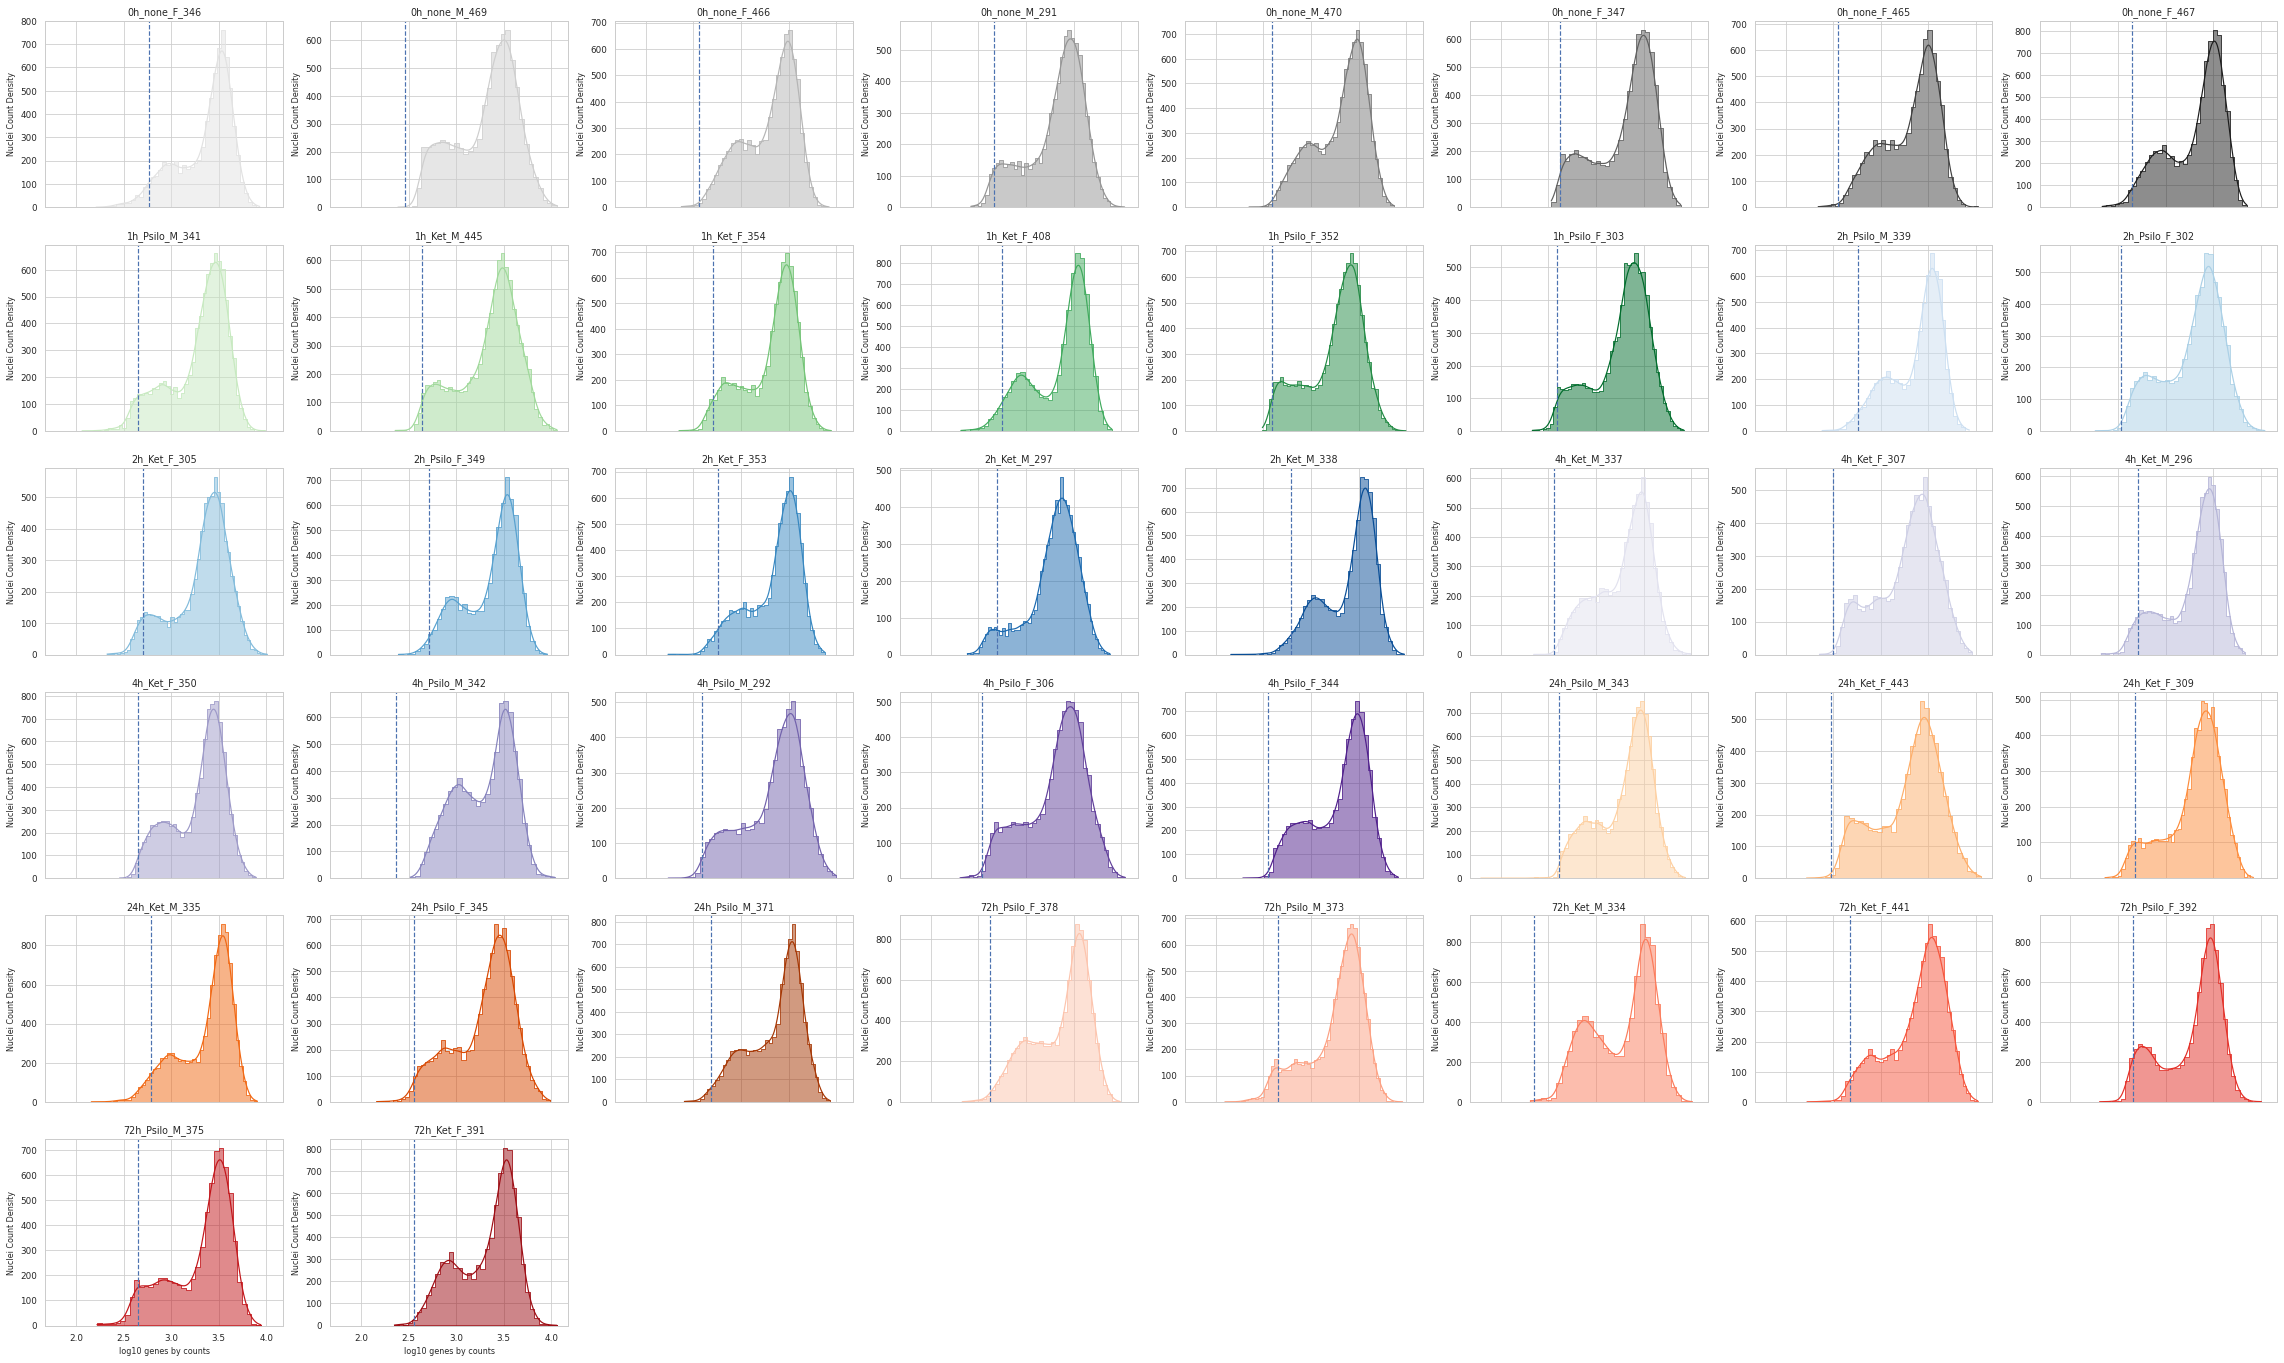

In [64]:
low_features_mask = plot_mask_feature_per_nuc(adata, feature='n_genes_by_counts',
                                        max_th=1000,
                                        xlab="log10 genes by counts")
plt.savefig( f"{settings.fig_path}/histogram_n_genes_per_cell.svg", format='svg', bbox_inches='tight')
plt.savefig( f"{settings.fig_path}/histogram_n_genes_per_cell.png", format='png', bbox_inches='tight')

In [65]:
# remove cells with low features per cell
adata = mask_cells(adata, ~low_features_mask)

Number of removed nuclei per sample:
72h_Psilo_M_373    531
24h_Ket_M_335      476
1h_Psilo_M_341     387
2h_Ket_F_305       378
2h_Ket_M_297       356
72h_Psilo_M_375    342
4h_Ket_M_296       342
0h_none_F_346      326
24h_Ket_F_309      313
72h_Psilo_F_392    311
1h_Ket_F_408       304
1h_Ket_F_354       266
2h_Ket_F_353       255
0h_none_M_291      252
2h_Ket_M_338       201
2h_Psilo_M_339     173
0h_none_F_467      158
1h_Psilo_F_303     122
72h_Ket_F_441      121
24h_Psilo_M_371    117
0h_none_F_347      109
2h_Psilo_F_349     108
1h_Ket_M_445       104
24h_Psilo_F_345    100
1h_Psilo_F_352      93
4h_Ket_F_350        69
72h_Psilo_F_378     60
4h_Psilo_M_292      41
0h_none_F_465       28
72h_Ket_F_391       28
0h_none_F_466       26
24h_Psilo_M_343     25
4h_Psilo_F_306      23
0h_none_M_470       20
4h_Psilo_F_344      15
2h_Psilo_F_302      15
24h_Ket_F_443        9
72h_Ket_M_334        5
4h_Ket_F_307         4
4h_Ket_M_337         3
0h_none_M_469        1
Total removed =  661

## Remove nuclei with high mitochondrial and ribosomal count percentages

In [66]:
# plot gene set percentages and return high nuc mask by median absolute deviation
def gene_set_MAD_plot_and_mask(adata, gene_mask, max_per, is_log_scale=True, mad_scale=3):
    # array to hold high mito per mask
    high_mk = np.array([False]*adata.shape[0], dtype=bool)

    # subplot params
    n    = len(adata.uns['label_order'])
    cols = 8
    rows = math.ceil(n / cols)
    size = cols * rows
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), sharex=True)
    # convert hard threshold if using logscale
    if(is_log_scale==True):
        max_per = np.log10(max_per)
    # loop through each sample
    for itr, (bat_itr, ax) in enumerate(zip(adata.uns['label_order'], axes.flatten())):
        bat_mk = adata.obs['label'].values==bat_itr
        bat_adata = adata[bat_mk,:]
        # get sum of mito counts
        gene_mk_sum = np.asarray(bat_adata[:,gene_mask].X.sum(1)).reshape(-1)
        # get summed counts for each nuc over all genes
        lib_sizes = np.asarray(bat_adata.X.sum(1)).reshape(-1)
        # get percentage of library size for masked counts
        if(is_log_scale==True):
            mk_per = np.log10(gene_mk_sum/lib_sizes.astype(float)*100 + 0.001)
        else:
            mk_per = gene_mk_sum/lib_sizes.astype(float)*100 + 0.001
        # calc median absolute deviation
        med_th = min(max_per, np.median(mk_per) + mad_scale * stats.median_abs_deviation(mk_per, scale='normal'))
        high_mk[bat_mk] = mk_per>med_th
        # plot on new subplot for each histogram
        plt.sca(ax)
        sd = sb.histplot(mk_per, kde=True, color=adata.uns['label_colors_dict'][bat_itr])
        if len(sd.get_lines()) > 0:
            x, y = sd.get_lines()[0].get_data()
            plt.vlines(med_th, 0, max(y), linestyles='dashed')
        plt.title(bat_itr)
        plt.ylabel("Nuclei Count Density", fontsize=8)
        if(is_log_scale==True):
            plt.xlabel("log10 percentages", fontsize=8)
        else:
            plt.xlabel("percentages", fontsize=8)
    # clear rest of graphs
    #for ii in range(itr+1, size):
    #    ax = axes.flatten()[ii]
    #    ax.axis('off')
    return(high_mk)

In [67]:
# Calculate mito percent
# pull all mito genes
mito_mask = adata.var["gene_name"].str.startswith('mt-')
mito_genes = adata.var_names.values[mito_mask]
# for each nuclei compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

/tmp/ipykernel_310597/92532595.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1


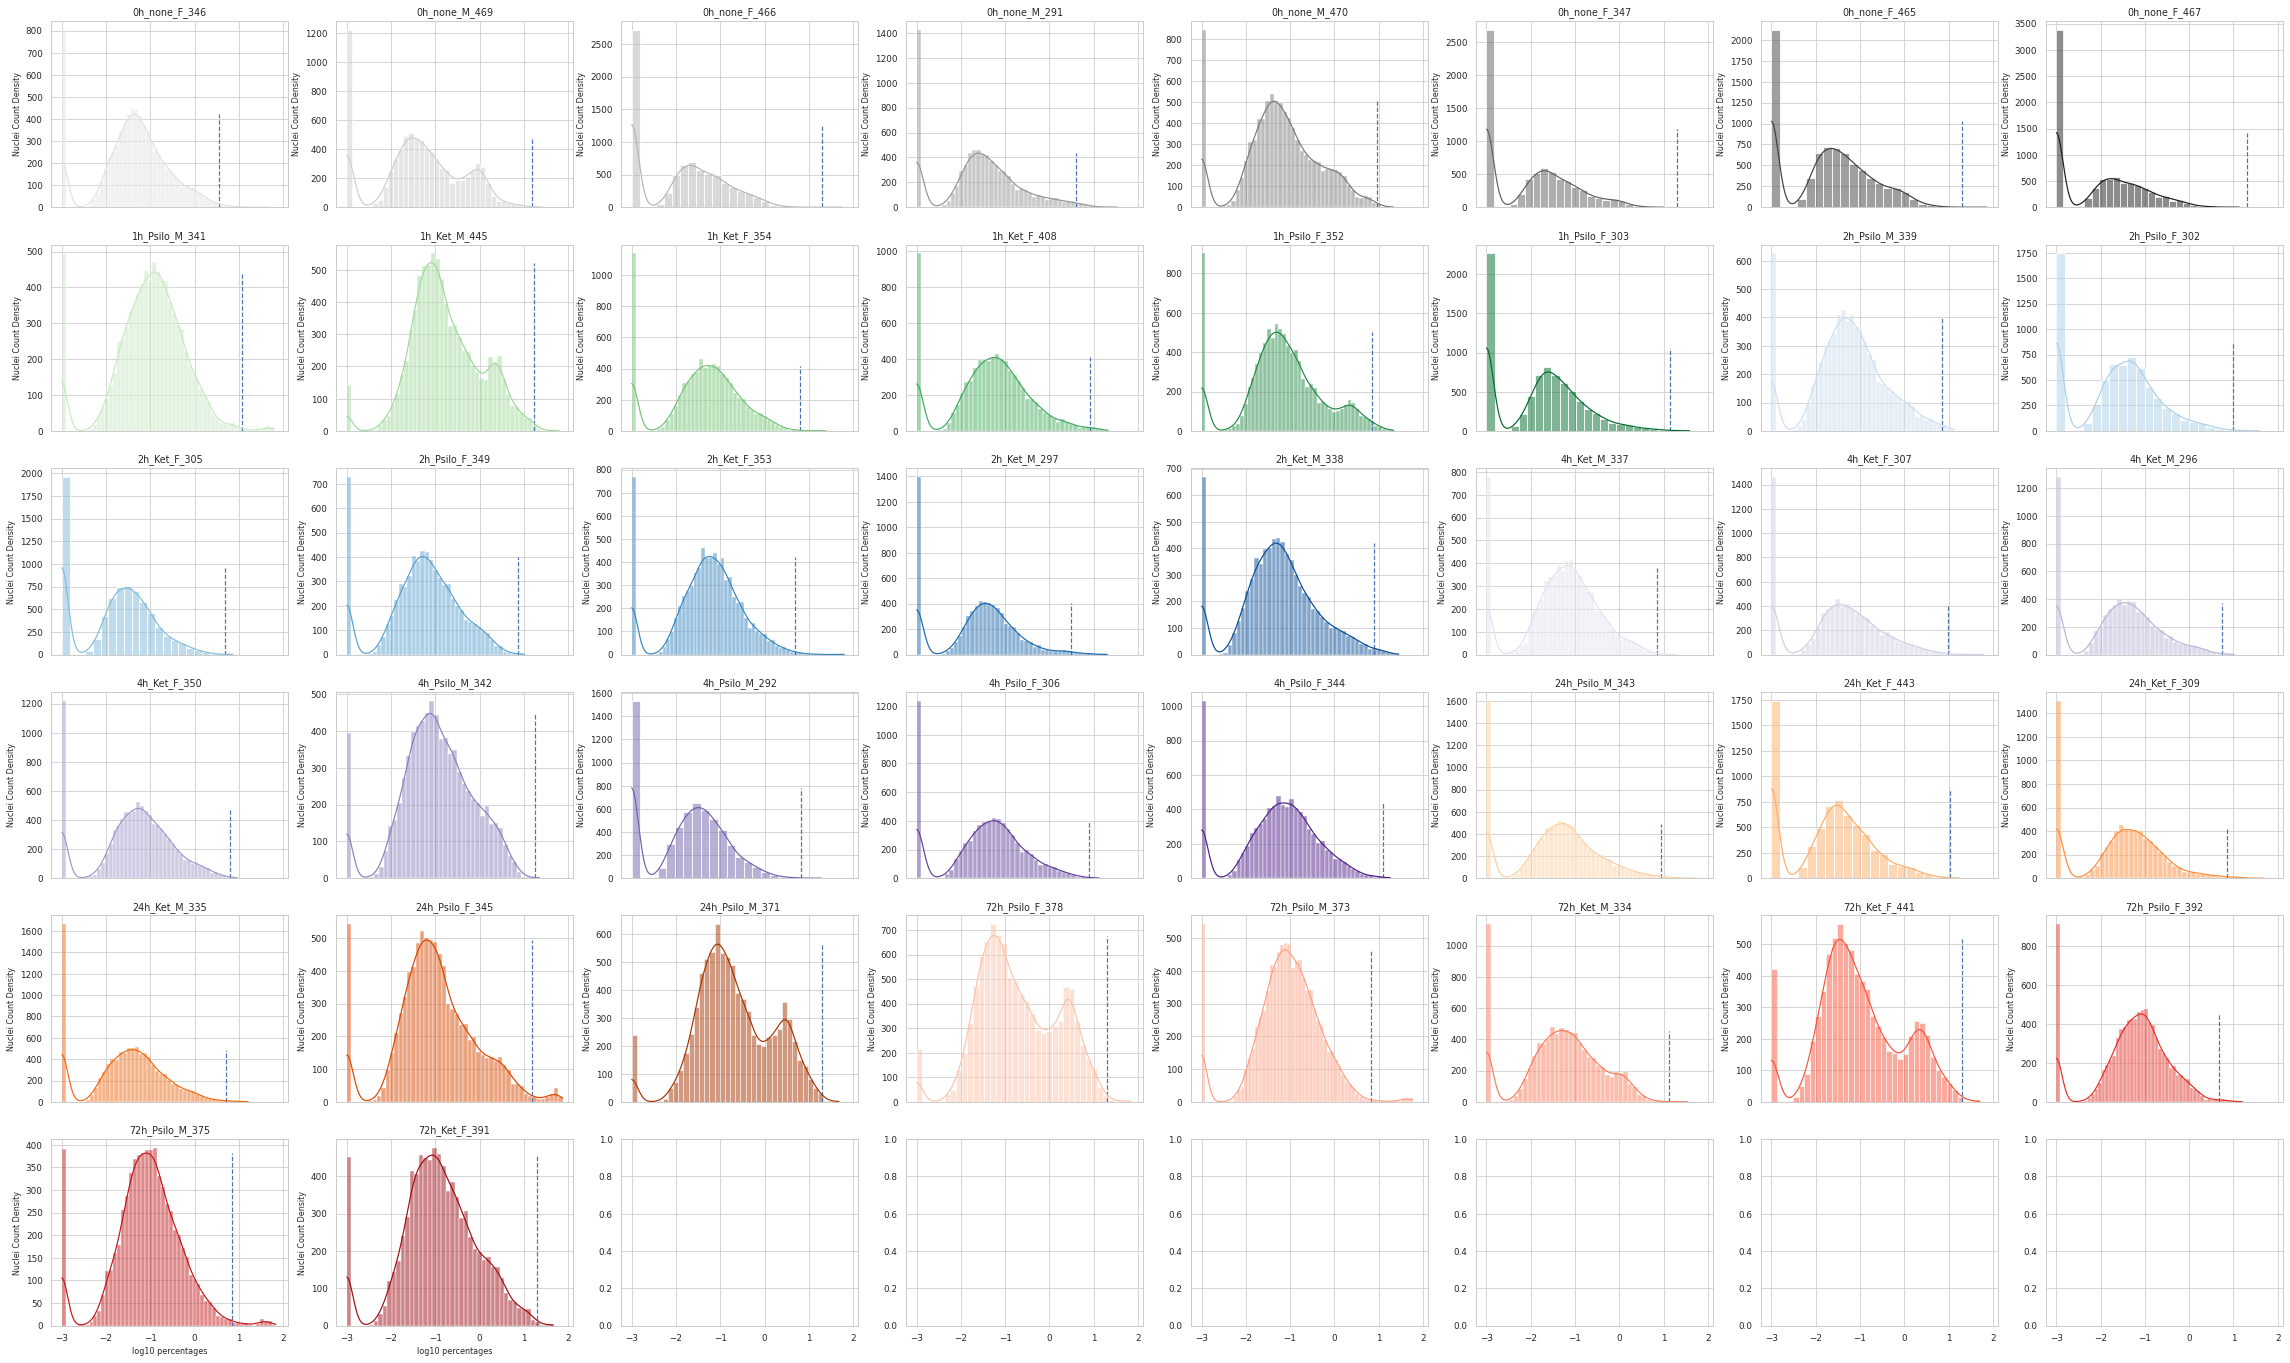

In [68]:
# remove all nuc with more than 3 MADs percentage mito gene counts
mito_per_mask = gene_set_MAD_plot_and_mask(adata, mito_mask, 20.0)
plt.savefig( f"{settings.fig_path}/histogram_mitochondrial_percentage.svg", format='svg', bbox_inches='tight')
plt.savefig( f"{settings.fig_path}/histogram_mitochondrial_percentage.png", format='png', bbox_inches='tight')

The ribosomal gene list was obtained from:
- http://ribosome.med.miyazaki-u.ac.jp/rpg.cgi?mode=orglist&org=Mus%20musculus
- http://ribosome.med.miyazaki-u.ac.jp/rpg.cgi?mode=orglist&org=Mus%20musculus&type=m

Use this in the browser console to scrape the lists
```
genes = document.getElementsByClassName("genes")
genelist = ""
for (let i = 0; i < genes.length; i++) {
    genelist = genelist + genes[i].innerText
}```

In [69]:
ribo_genes = pd.read_table("../ribosomal_genes.txt", names=["genes"])
# create mask for all ribo genes
ribo_mk = np.in1d(adata.var["gene_name"], ribo_genes)
adata.obs['percent_ribo'] = np.sum(adata[:,ribo_mk].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

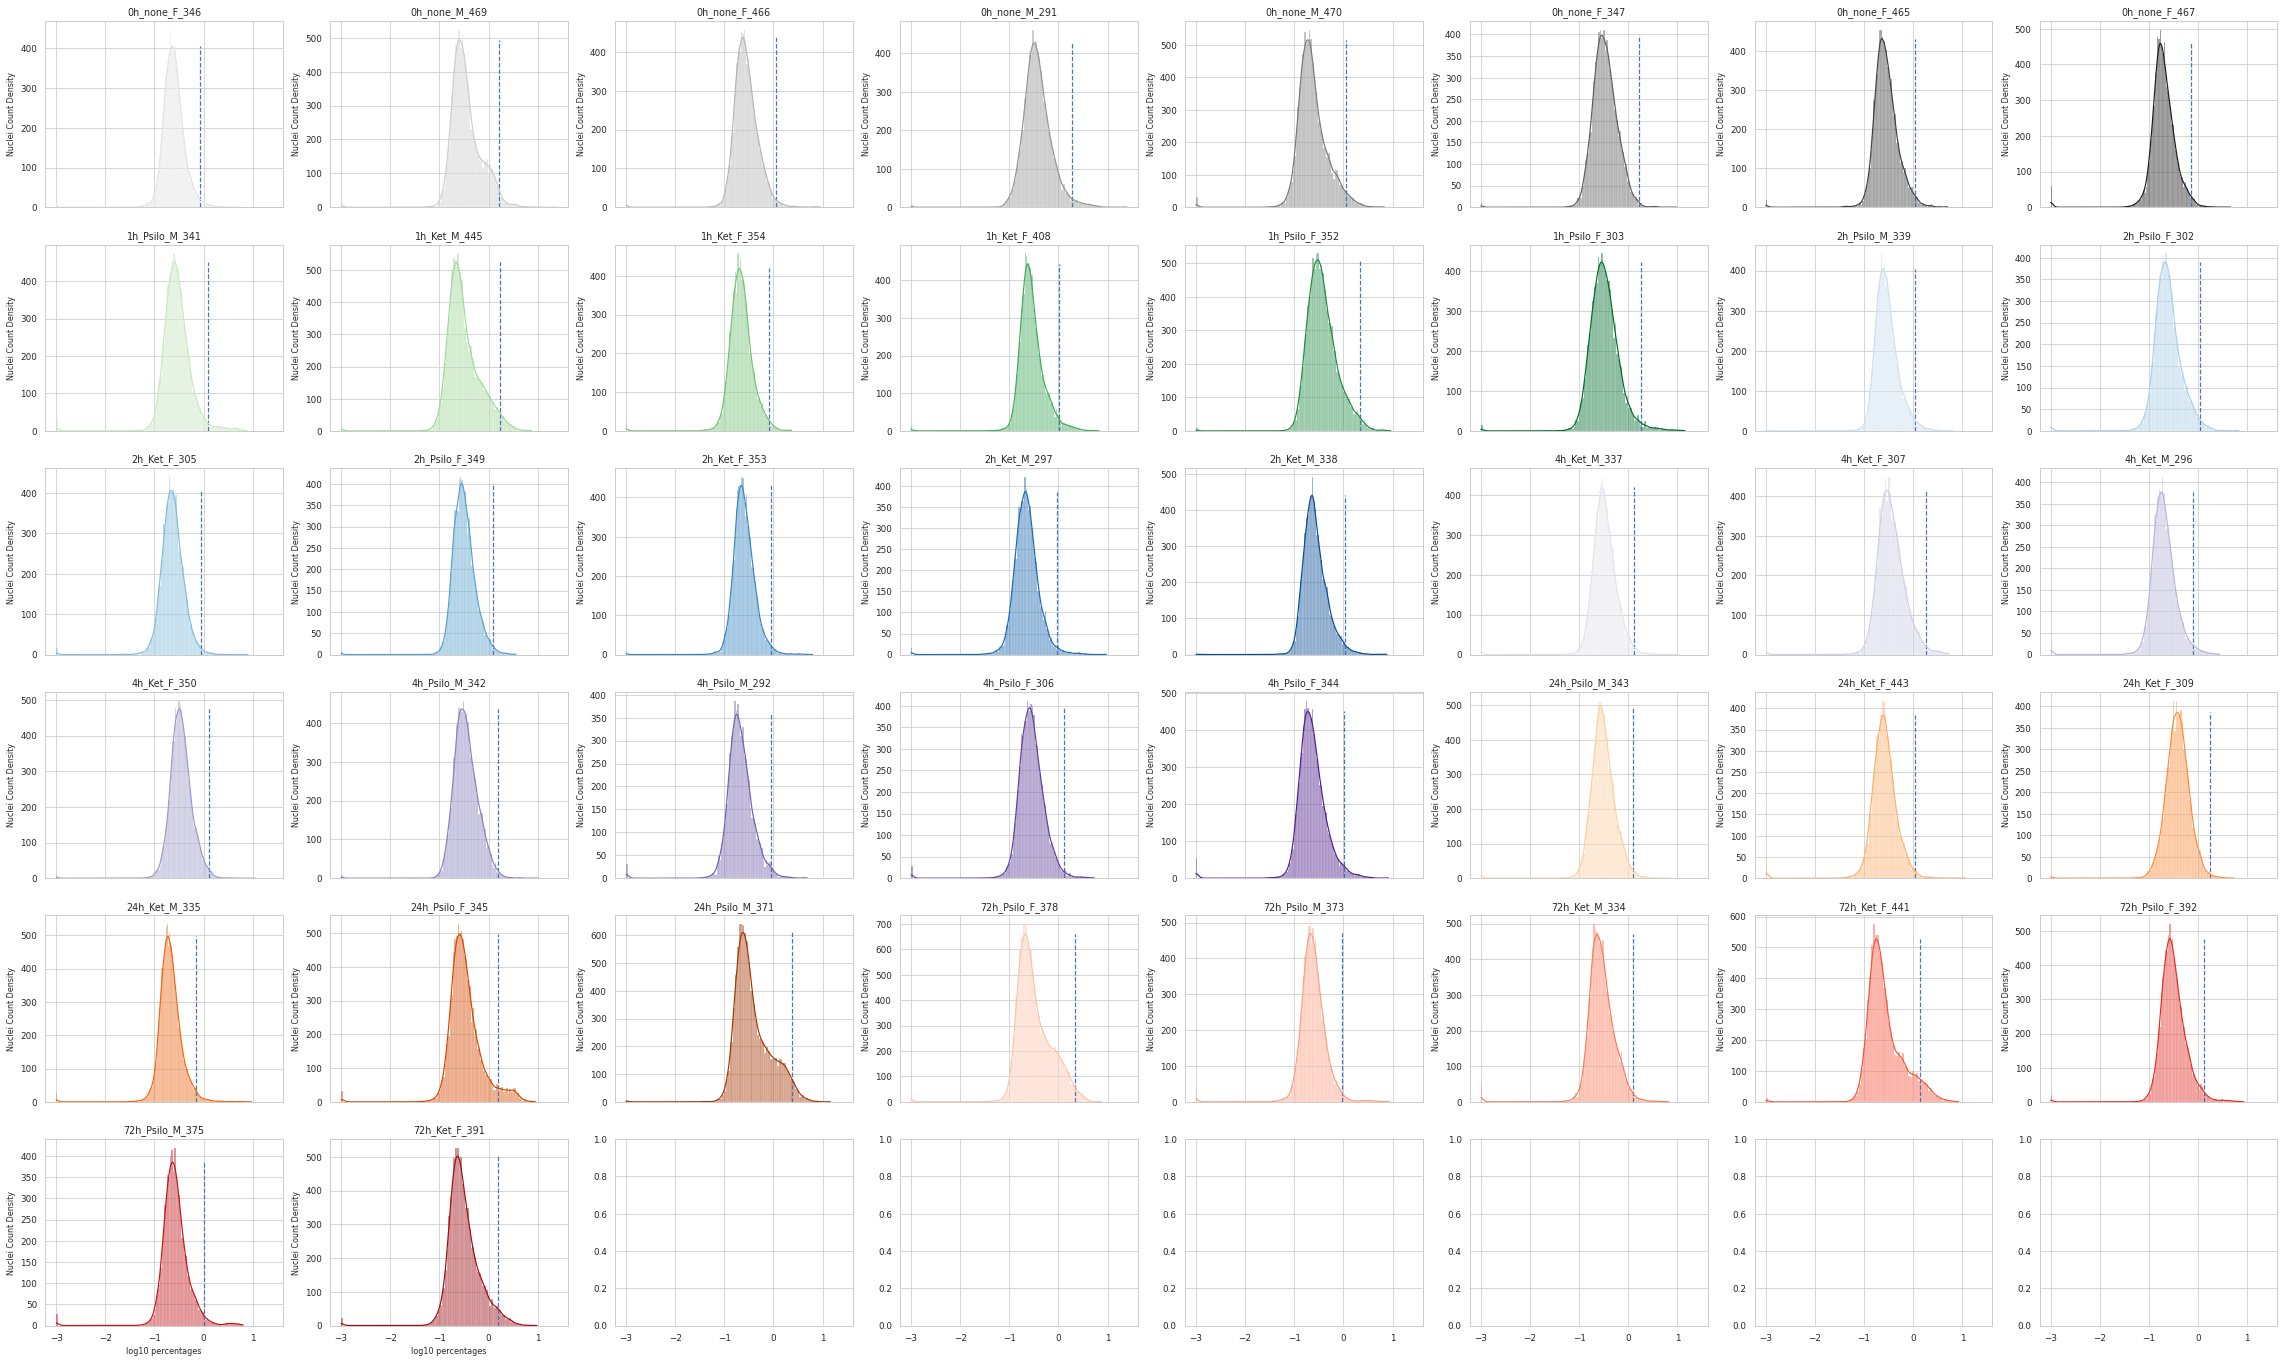

In [70]:
# remove all nuc with more than 3 MADs percentage ribo gene counts
ribo_per_mk = gene_set_MAD_plot_and_mask(adata, ribo_mk, 20.0)
plt.savefig( f"{settings.fig_path}/histogram_ribosomal_percentage.svg", format='svg', bbox_inches='tight')
plt.savefig( f"{settings.fig_path}/histogram_ribosomal_percentage.png", format='png', bbox_inches='tight')

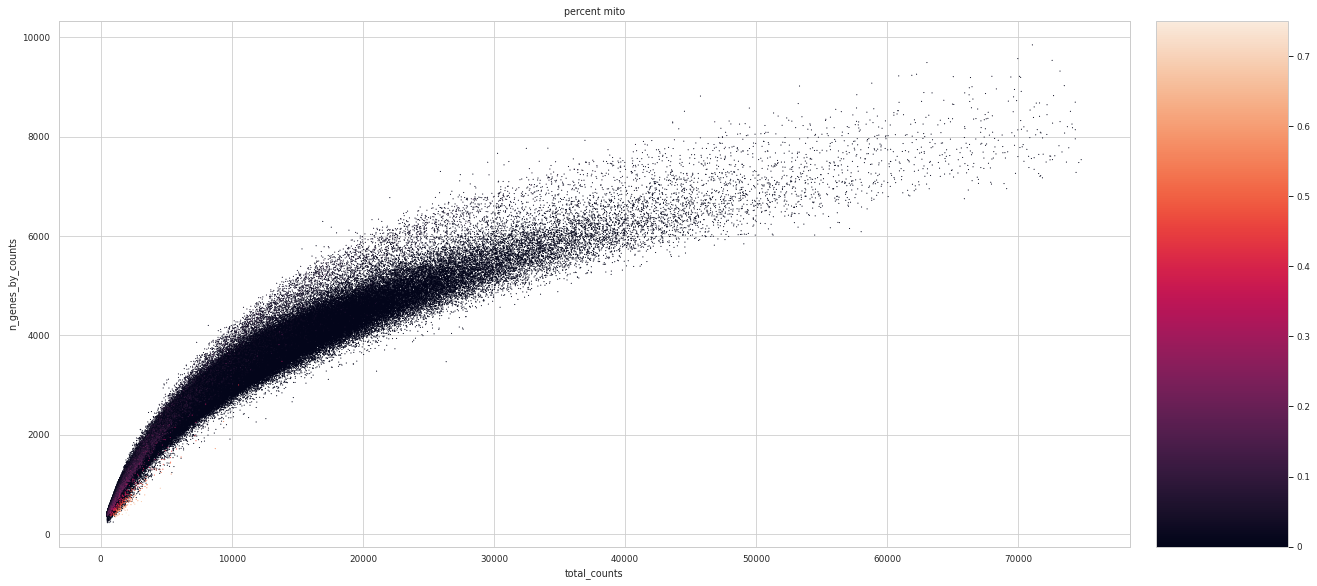

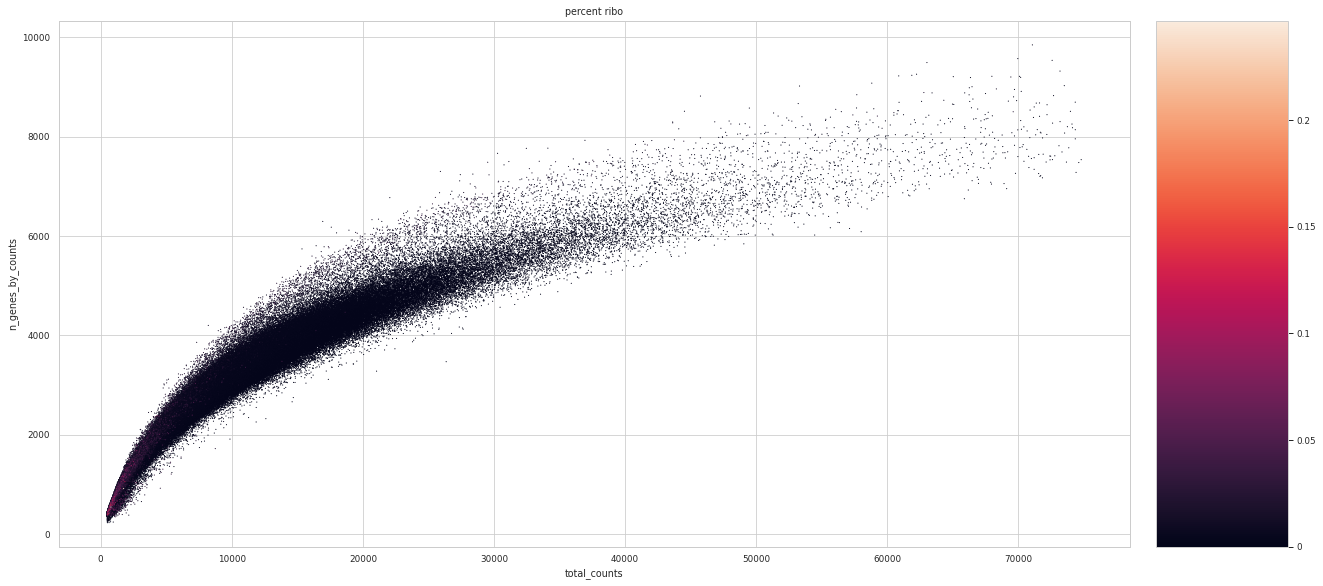

In [71]:
with plt.rc_context({'figure.figsize': (15,10)}):
    sc.pl.scatter(adata[(adata.obs['total_counts']<75000)], 'total_counts', 'n_genes_by_counts',
                  color="percent_mito", show=False, size=5)    
    sc.pl.scatter(adata[adata.obs['total_counts']<75000], 'total_counts', 'n_genes_by_counts',
                  color="percent_ribo", show=False, size=5)

In [72]:
combined_mk = (ribo_per_mk + mito_per_mask)
adata = mask_cells(adata, ~combined_mk)

Number of removed nuclei per sample:
24h_Psilo_F_345    505
72h_Ket_F_441      445
72h_Ket_F_391      284
24h_Psilo_M_371    274
0h_none_M_470      267
1h_Ket_M_445       261
1h_Ket_F_408       239
1h_Psilo_F_352     212
72h_Psilo_F_378    206
0h_none_M_291      205
1h_Psilo_M_341     203
4h_Psilo_F_344     191
24h_Ket_M_335      190
0h_none_M_469      179
72h_Psilo_F_392    173
2h_Ket_M_338       173
72h_Psilo_M_375    161
1h_Psilo_F_303     146
72h_Psilo_M_373    146
2h_Psilo_M_339     144
0h_none_F_467      140
0h_none_F_465      138
2h_Ket_M_297       136
4h_Ket_M_296       127
2h_Ket_F_353       125
4h_Ket_F_307       124
2h_Psilo_F_302     123
0h_none_F_346      123
24h_Psilo_M_343    114
72h_Ket_M_334      110
1h_Ket_F_354       105
0h_none_F_466      103
4h_Psilo_M_292      94
4h_Ket_F_350        93
4h_Ket_M_337        83
2h_Psilo_F_349      82
4h_Psilo_F_306      80
24h_Ket_F_443       75
2h_Ket_F_305        63
24h_Ket_F_309       59
4h_Psilo_M_342      55
0h_none_F_347       

## Check for highly expressed genes

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, 

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, 

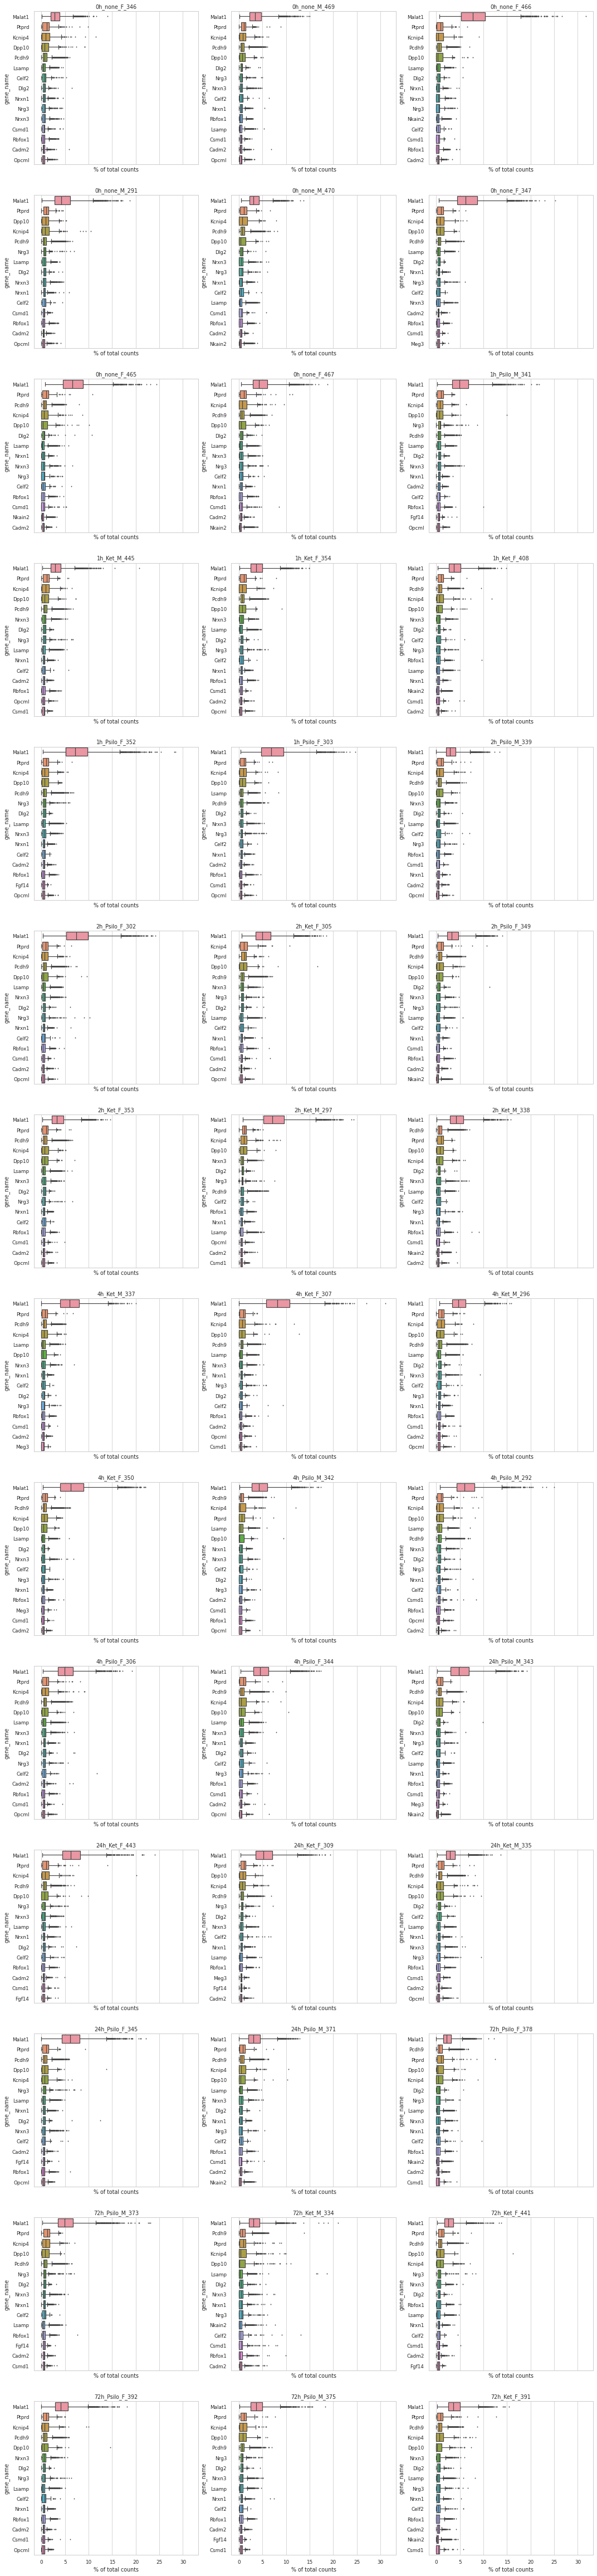

In [73]:
# plot highly expressed genes for each sample
n = len(adata.uns['label_order'])
fig, axes = plt.subplots(math.ceil(n/3), 3, figsize=(18, math.ceil(n/3)*6), sharex=True)
# loop through each sample
for itr, (bat_itr, ax) in enumerate(zip(adata.uns['label_order'], axes.flatten())):
    bat_mk = adata.obs['label']==bat_itr
    bat_adata = adata[bat_mk,:].copy()
    plt.sca(ax)
    sc.pl.highest_expr_genes(bat_adata, n_top=15, ax=ax, show=False)
    plt.title(bat_itr)
plt.savefig(f"{settings.fig_path}/highly-expressed.png", format='png', bbox_inches='tight')

Malat1 is known to be overexpressed and can affect normalization. Highly expressed genes also have a large variance, so normal flucuations can have an outsized effect on library normalization. 

In [74]:
# Remove mito and ribo genes
adata = adata[:,~np.in1d( adata.var_names, np.append( mito_genes, ribo_genes))]

In [75]:
# Remove Malat1
genes_to_remove = [
    "Malat1",
]
adata = adata[:,(~np.isin(adata.var_names, genes_to_remove))]

In [76]:
adata

View of AnnData object with n_obs × n_vars = 326118 × 27165
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells'
    uns: 'label_order', 'label_colors', 'label_colors_dict', 'stage_order', 'stage_colors_dict', 'scrublet'

# Save adata

In [77]:
adata.write(f"{settings.fig_path}/cleaned_count_matrices.h5ad")

In [78]:
del adata